In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [10]:
def build_2d_cnn_only_conv_BN(conv_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [11]:
# for i in range(1, 5):
#     model = build_2d_cnn_only_conv_BN(conv_num=i)
#     model.summary()
#     del model

In [12]:
# model = build_cnn(conv_num=3, fcn_num=1)
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.6227 - acc: 0.5090
Epoch 00001: val_loss improved from inf to 1.50162, saving model to model/checkpoint/2D_CNN_1_only_conv_BN_checkpoint/01-1.5016.hdf5
36805/36805 [==============================] - 12s 329us/sample - loss: 1.6227 - acc: 0.5090 - val_loss: 1.5016 - val_acc: 0.5667
Epoch 2/200
36608/36805 [============================>.] - ETA: 0s - loss: 1.1932 - acc: 0.6424
Epoch 00002: val_loss improved from 1.50162 to 1.29336, saving model to model/checkpoint/2D_CNN_1_only_conv_BN_checkpoint/02-1.2934.hdf5
36805/36805 [==============================] - 11s 296us/sample - loss: 1.1936 - acc: 0.6423 - val_loss: 1.2934 - val_acc: 0.6296
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0007 - acc: 0.6981
Epoch 00003: 

36672/36805 [============================>.] - ETA: 0s - loss: 0.1257 - acc: 0.9759
Epoch 00027: val_loss did not improve from 1.25351
36805/36805 [==============================] - 10s 277us/sample - loss: 0.1260 - acc: 0.9758 - val_loss: 1.7867 - val_acc: 0.6727
Epoch 28/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1326 - acc: 0.9719
Epoch 00028: val_loss did not improve from 1.25351
36805/36805 [==============================] - 10s 265us/sample - loss: 0.1326 - acc: 0.9719 - val_loss: 1.7238 - val_acc: 0.6834
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1117 - acc: 0.9804
Epoch 00029: val_loss did not improve from 1.25351
36805/36805 [==============================] - 10s 267us/sample - loss: 0.1118 - acc: 0.9804 - val_loss: 1.7660 - val_acc: 0.6848
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1018 - acc: 0.9824
Epoch 00030: val_loss did not improve from 1.25351
36805/36805 [==================

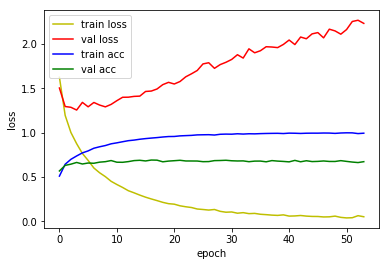

4815/4815 [==============================] - 1s 187us/sample - loss: 1.3394 - acc: 0.6247
Loss: 1.3394468820478809 Accuracy: 0.62471443

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.5567 - acc: 0.5272
Epoch 00001: val_loss improved from inf to 1.29771, saving model to model/checkpoint/2D_CNN_2_only_conv_BN_checkpoint/01-1.2977.hdf5
36805/36805 [==============================] - 14s 377us/sample - loss: 1.5559 - acc: 0.5275 - val_loss: 1.2977 - val_acc: 0.6103
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.0737 - acc: 0.6823
Epoch 00002: val_loss improved from 1.29771 to 1.05539, saving model to model/checkpoint/2D_CNN_2_only_conv_BN_checkpoint/02-1.0554.hdf5
36805/36805 [==============================] - 13s 340us/sample - loss: 1.0733 - acc: 0.6825 - val_loss: 1.0554 - val_acc: 0.7091
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.8445 - acc: 0.7

36736/36805 [============================>.] - ETA: 0s - loss: 0.0731 - acc: 0.9872
Epoch 00027: val_loss did not improve from 0.60990
36805/36805 [==============================] - 12s 333us/sample - loss: 0.0731 - acc: 0.9871 - val_loss: 0.7393 - val_acc: 0.8495
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9886
Epoch 00028: val_loss did not improve from 0.60990
36805/36805 [==============================] - 12s 335us/sample - loss: 0.0672 - acc: 0.9886 - val_loss: 0.7406 - val_acc: 0.8535
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9908
Epoch 00029: val_loss did not improve from 0.60990
36805/36805 [==============================] - 12s 337us/sample - loss: 0.0608 - acc: 0.9908 - val_loss: 0.7542 - val_acc: 0.8479
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9886
Epoch 00030: val_loss did not improve from 0.60990
36805/36805 [==================

Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9975
Epoch 00057: val_loss did not improve from 0.60990
36805/36805 [==============================] - 13s 341us/sample - loss: 0.0179 - acc: 0.9975 - val_loss: 0.9724 - val_acc: 0.8423
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9984
Epoch 00058: val_loss did not improve from 0.60990
36805/36805 [==============================] - 12s 336us/sample - loss: 0.0147 - acc: 0.9984 - val_loss: 0.9472 - val_acc: 0.8495
Epoch 59/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9969
Epoch 00059: val_loss did not improve from 0.60990
36805/36805 [==============================] - 12s 337us/sample - loss: 0.0190 - acc: 0.9969 - val_loss: 1.1644 - val_acc: 0.8185
Epoch 60/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9959
Epoch 00060: val_loss did not improve from 0.60990
36805/36805 [=====

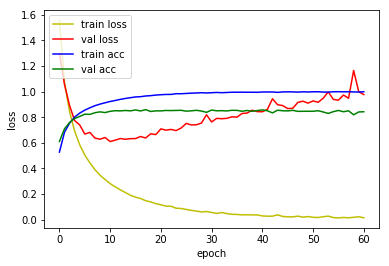

4815/4815 [==============================] - 1s 214us/sample - loss: 0.7185 - acc: 0.8106
Loss: 0.7185422250291145 Accuracy: 0.8105919

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.6191 - acc: 0.5000
Epoch 00001: val_loss improved from inf to 1.17374, saving model to model/checkpoint/2D_CNN_3_only_conv_BN_checkpoint/01-1.1737.hdf5
36805/36805 [==============================] - 16s 429us/sample - loss: 1.6183 - acc: 0.5003 - val_loss: 1.1737 - val_acc: 0.6676
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9515 - acc: 0.7213- ETA: 0s - loss: 0.9574 - a
Epoch 00002: val_loss improved from 1.17374 to 0.82342, saving model to model/checkpoint/2D_CNN_3_only_conv_BN_checkpoint/02-0.8234.hdf5
36805/36805 [==============================] - 14s 388us/sample - loss: 0.9514 - acc: 0.7213 - val_loss: 0.8234 - val_acc: 0.7708
Epoch 3/200
36736/36805 [============================>.] - ETA: 0

Epoch 26/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0847 - acc: 0.9810
Epoch 00026: val_loss did not improve from 0.35634
36805/36805 [==============================] - 14s 386us/sample - loss: 0.0846 - acc: 0.9810 - val_loss: 0.3704 - val_acc: 0.9115
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0811 - acc: 0.9813
Epoch 00027: val_loss did not improve from 0.35634
36805/36805 [==============================] - 14s 384us/sample - loss: 0.0811 - acc: 0.9813 - val_loss: 0.4013 - val_acc: 0.8998
Epoch 28/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0747 - acc: 0.9829
Epoch 00028: val_loss did not improve from 0.35634
36805/36805 [==============================] - 14s 390us/sample - loss: 0.0746 - acc: 0.9829 - val_loss: 0.3960 - val_acc: 0.9043
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9859
Epoch 00029: val_loss did not improve from 0.35634
36805/36805 [=====

Epoch 56/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9974
Epoch 00056: val_loss did not improve from 0.35634
36805/36805 [==============================] - 14s 389us/sample - loss: 0.0175 - acc: 0.9974 - val_loss: 0.4507 - val_acc: 0.9061
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9974
Epoch 00057: val_loss did not improve from 0.35634
36805/36805 [==============================] - 14s 388us/sample - loss: 0.0178 - acc: 0.9973 - val_loss: 0.4800 - val_acc: 0.9064
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9974
Epoch 00058: val_loss did not improve from 0.35634
36805/36805 [==============================] - 14s 389us/sample - loss: 0.0175 - acc: 0.9974 - val_loss: 0.4965 - val_acc: 0.9005
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9961
Epoch 00059: val_loss did not improve from 0.35634
36805/36805 [=====

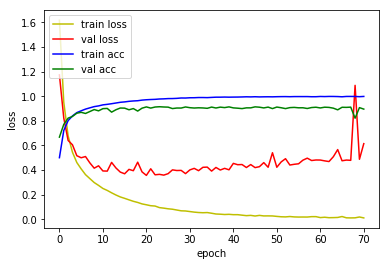

4815/4815 [==============================] - 1s 224us/sample - loss: 0.4240 - acc: 0.8739
Loss: 0.4240320925772004 Accuracy: 0.87393564

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.6210 - acc: 0.5019
Epoch 00001: val_loss improved from inf to 1.07194, saving model to model/checkpoint/2D_CNN_4_only_conv_BN_checkpoint/01-1.0719.hdf5
36805/36805 [==============================] - 18s 482us/sample - loss: 1.6200 - acc: 0.5023 - val_loss: 1.0719 - val_acc: 0.6811
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.8289 - acc: 0.7571
Epoch 00002: val_loss improved from 1.07194 to 0.66957, saving model to model/checkpoint/2D_CNN_4_only_conv_BN_checkpoint/02-0.6696.hdf5
36805/36805 [==============================] - 15s 412us/sample - loss: 0.8291 - acc: 0.7571 - val_loss: 0.6696 - val_acc: 0.8090
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.5838 - acc: 0.8

36672/36805 [============================>.] - ETA: 0s - loss: 0.0706 - acc: 0.9839
Epoch 00025: val_loss did not improve from 0.24508
36805/36805 [==============================] - 15s 408us/sample - loss: 0.0705 - acc: 0.9840 - val_loss: 0.2768 - val_acc: 0.9350
Epoch 26/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9862
Epoch 00026: val_loss did not improve from 0.24508
36805/36805 [==============================] - 15s 414us/sample - loss: 0.0638 - acc: 0.9862 - val_loss: 0.2722 - val_acc: 0.9308
Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9877
Epoch 00027: val_loss did not improve from 0.24508
36805/36805 [==============================] - 15s 412us/sample - loss: 0.0586 - acc: 0.9876 - val_loss: 0.2482 - val_acc: 0.9385
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0556 - acc: 0.9884
Epoch 00028: val_loss did not improve from 0.24508
36805/36805 [==================

36736/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9949
Epoch 00054: val_loss did not improve from 0.23836
36805/36805 [==============================] - 15s 415us/sample - loss: 0.0244 - acc: 0.9949 - val_loss: 0.2826 - val_acc: 0.9427
Epoch 55/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9972
Epoch 00055: val_loss did not improve from 0.23836
36805/36805 [==============================] - 15s 421us/sample - loss: 0.0154 - acc: 0.9972 - val_loss: 0.3310 - val_acc: 0.9297
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9943
Epoch 00056: val_loss did not improve from 0.23836
36805/36805 [==============================] - 15s 419us/sample - loss: 0.0249 - acc: 0.9943 - val_loss: 0.2831 - val_acc: 0.9420
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0138 - acc: 0.9975
Epoch 00057: val_loss did not improve from 0.23836
36805/36805 [==================

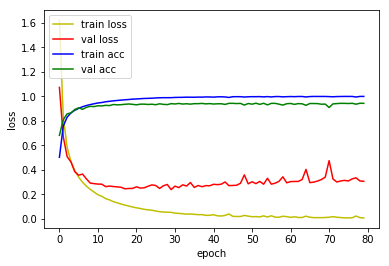

4815/4815 [==============================] - 1s 281us/sample - loss: 0.3115 - acc: 0.9134
Loss: 0.31153705196217213 Accuracy: 0.91339564



In [13]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_BN'.format(i)
    model = build_2d_cnn_only_conv_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print('{} Only Conv Model'.format(i))
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()
    
    del(model)

In [14]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


2D_CNN_1_only_conv_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 8)        32        
_________________________________________________________________
activation (Activation)      (None, 253, 95, 8)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 8)        0         
_________________________________________________________________
flatten (Flatten)            (None, 48768)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                780304    
Total params: 780,544
Trainable params: 780,528
Non-trainable params: 16
________________________________________

4815/4815 [==============================] - 1s 298us/sample - loss: 0.3115 - acc: 0.9134
Loss: 0.31153705196217213 Accuracy: 0.91339564


In [15]:
def build_2d_cnn_only_conv_BN_2(conv_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.7245 - acc: 0.5169
Epoch 00001: val_loss improved from inf to 1.45218, saving model to model/checkpoint/2D_CNN_1_only_conv_BN_2_checkpoint/01-1.4522.hdf5
36805/36805 [==============================] - 15s 416us/sample - loss: 1.7243 - acc: 0.5169 - val_loss: 1.4522 - val_acc: 0.5875
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1630 - acc: 0.6637
Epoch 00002: val_loss improved from 1.45218 to 1.33755, saving model to model/checkpoint/2D_CNN_1_only_conv_BN_2_checkpoint/02-1.3376.hdf5
36805/36805 [==============================] - 11s 298us/sample - loss: 1.1631 - acc: 0.6636 - val_loss: 1.3376 - val_acc: 0.6355
Epoch 3/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.8585 - acc: 0.7426
Epoch 00003: val_loss did not improve from 1.33755
36805/36805 [==============================] - 11s 296us/sample - loss: 0.8591

36672/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9907
Epoch 00029: val_loss did not improve from 1.27234
36805/36805 [==============================] - 11s 298us/sample - loss: 0.0489 - acc: 0.9906 - val_loss: 1.9080 - val_acc: 0.6641
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9886
Epoch 00030: val_loss did not improve from 1.27234
36805/36805 [==============================] - 11s 298us/sample - loss: 0.0544 - acc: 0.9885 - val_loss: 1.8885 - val_acc: 0.6562
Epoch 31/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9906
Epoch 00031: val_loss did not improve from 1.27234
36805/36805 [==============================] - 11s 298us/sample - loss: 0.0464 - acc: 0.9906 - val_loss: 1.8859 - val_acc: 0.6618
Epoch 32/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9930
Epoch 00032: val_loss did not improve from 1.27234
36805/36805 [==================

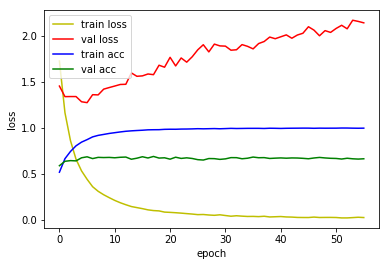

4815/4815 [==============================] - 1s 284us/sample - loss: 1.3738 - acc: 0.6442
Loss: 1.3738153039233088 Accuracy: 0.64423674

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.5921 - acc: 0.5303
Epoch 00001: val_loss improved from inf to 1.24174, saving model to model/checkpoint/2D_CNN_2_only_conv_BN_2_checkpoint/01-1.2417.hdf5
36805/36805 [==============================] - 18s 500us/sample - loss: 1.5902 - acc: 0.5307 - val_loss: 1.2417 - val_acc: 0.6478
Epoch 2/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.0120 - acc: 0.6996
Epoch 00002: val_loss improved from 1.24174 to 1.04770, saving model to model/checkpoint/2D_CNN_2_only_conv_BN_2_checkpoint/02-1.0477.hdf5
36805/36805 [==============================] - 13s 359us/sample - loss: 1.0112 - acc: 0.7000 - val_loss: 1.0477 - val_acc: 0.7011
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.7452 - acc:

Epoch 27/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9943
Epoch 00027: val_loss did not improve from 0.73547
36805/36805 [==============================] - 13s 355us/sample - loss: 0.0364 - acc: 0.9942 - val_loss: 0.9311 - val_acc: 0.8062
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0338 - acc: 0.9945
Epoch 00028: val_loss did not improve from 0.73547
36805/36805 [==============================] - 13s 358us/sample - loss: 0.0338 - acc: 0.9945 - val_loss: 1.0136 - val_acc: 0.7920
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9944
Epoch 00029: val_loss did not improve from 0.73547
36805/36805 [==============================] - 13s 353us/sample - loss: 0.0350 - acc: 0.9944 - val_loss: 0.8707 - val_acc: 0.8171
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9952
Epoch 00030: val_loss did not improve from 0.73547
36805/36805 [=====

Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9987
Epoch 00057: val_loss did not improve from 0.73547
36805/36805 [==============================] - 13s 354us/sample - loss: 0.0101 - acc: 0.9987 - val_loss: 1.0789 - val_acc: 0.8081
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9980
Epoch 00058: val_loss did not improve from 0.73547
36805/36805 [==============================] - 13s 360us/sample - loss: 0.0125 - acc: 0.9979 - val_loss: 1.0336 - val_acc: 0.8130
Epoch 59/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0138 - acc: 0.9978
Epoch 00059: val_loss did not improve from 0.73547
36805/36805 [==============================] - 13s 364us/sample - loss: 0.0138 - acc: 0.9979 - val_loss: 1.0544 - val_acc: 0.8053

2 Only Conv Model


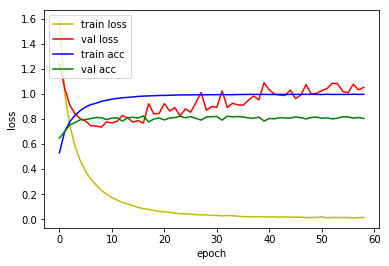

4815/4815 [==============================] - 1s 282us/sample - loss: 0.8319 - acc: 0.7811
Loss: 0.831859715878654 Accuracy: 0.78110075

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.6336 - acc: 0.5032
Epoch 00001: val_loss improved from inf to 1.15589, saving model to model/checkpoint/2D_CNN_3_only_conv_BN_2_checkpoint/01-1.1559.hdf5
36805/36805 [==============================] - 22s 607us/sample - loss: 1.6319 - acc: 0.5037 - val_loss: 1.1559 - val_acc: 0.6625
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.9709 - acc: 0.7152
Epoch 00002: val_loss improved from 1.15589 to 0.84408, saving model to model/checkpoint/2D_CNN_3_only_conv_BN_2_checkpoint/02-0.8441.hdf5
36805/36805 [==============================] - 15s 404us/sample - loss: 0.9712 - acc: 0.7151 - val_loss: 0.8441 - val_acc: 0.7747
Epoch 3/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.7026 - acc: 

36672/36805 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9840
Epoch 00026: val_loss did not improve from 0.35820
36805/36805 [==============================] - 15s 402us/sample - loss: 0.0708 - acc: 0.9840 - val_loss: 0.3809 - val_acc: 0.9052
Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0663 - acc: 0.9852
Epoch 00027: val_loss did not improve from 0.35820
36805/36805 [==============================] - 15s 396us/sample - loss: 0.0665 - acc: 0.9852 - val_loss: 0.3814 - val_acc: 0.9075
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0630 - acc: 0.9863
Epoch 00028: val_loss did not improve from 0.35820
36805/36805 [==============================] - 15s 402us/sample - loss: 0.0635 - acc: 0.9862 - val_loss: 0.4179 - val_acc: 0.9001
Epoch 29/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0658 - acc: 0.9851
Epoch 00029: val_loss did not improve from 0.35820
36805/36805 [==================

Epoch 56/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9955
Epoch 00056: val_loss did not improve from 0.35820
36805/36805 [==============================] - 14s 392us/sample - loss: 0.0222 - acc: 0.9955 - val_loss: 0.4484 - val_acc: 0.8987
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9941
Epoch 00057: val_loss did not improve from 0.35820
36805/36805 [==============================] - 15s 398us/sample - loss: 0.0258 - acc: 0.9941 - val_loss: 0.4486 - val_acc: 0.9057
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0186 - acc: 0.9964
Epoch 00058: val_loss did not improve from 0.35820
36805/36805 [==============================] - 15s 402us/sample - loss: 0.0188 - acc: 0.9963 - val_loss: 0.5143 - val_acc: 0.8884
Epoch 59/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9938
Epoch 00059: val_loss did not improve from 0.35820
36805/36805 [=====

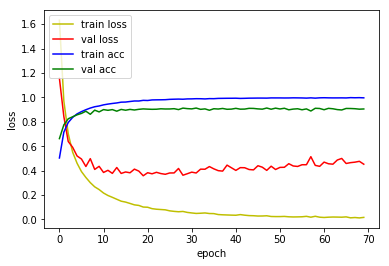

4815/4815 [==============================] - 2s 318us/sample - loss: 0.4344 - acc: 0.8771
Loss: 0.4344429580222038 Accuracy: 0.8770509

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.7636 - acc: 0.4598
Epoch 00001: val_loss improved from inf to 1.20908, saving model to model/checkpoint/2D_CNN_4_only_conv_BN_2_checkpoint/01-1.2091.hdf5
36805/36805 [==============================] - 24s 641us/sample - loss: 1.7623 - acc: 0.4603 - val_loss: 1.2091 - val_acc: 0.6303
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.9913 - acc: 0.7058
Epoch 00002: val_loss improved from 1.20908 to 0.79319, saving model to model/checkpoint/2D_CNN_4_only_conv_BN_2_checkpoint/02-0.7932.hdf5
36805/36805 [==============================] - 15s 410us/sample - loss: 0.9914 - acc: 0.7058 - val_loss: 0.7932 - val_acc: 0.7759
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6894 - acc: 

Epoch 25/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0802 - acc: 0.9800
Epoch 00025: val_loss did not improve from 0.24947
36805/36805 [==============================] - 16s 430us/sample - loss: 0.0801 - acc: 0.9800 - val_loss: 0.2636 - val_acc: 0.9285
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0745 - acc: 0.9825
Epoch 00026: val_loss did not improve from 0.24947
36805/36805 [==============================] - 16s 428us/sample - loss: 0.0746 - acc: 0.9825 - val_loss: 0.2660 - val_acc: 0.9320
Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0722 - acc: 0.9824
Epoch 00027: val_loss did not improve from 0.24947
36805/36805 [==============================] - 15s 412us/sample - loss: 0.0721 - acc: 0.9824 - val_loss: 0.2665 - val_acc: 0.9327
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0663 - acc: 0.9841
Epoch 00028: val_loss did not improve from 0.24947
36805/36805 [=====

Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9925
Epoch 00055: val_loss did not improve from 0.24947
36805/36805 [==============================] - 17s 456us/sample - loss: 0.0316 - acc: 0.9924 - val_loss: 0.2902 - val_acc: 0.9343
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9934
Epoch 00056: val_loss did not improve from 0.24947
36805/36805 [==============================] - 17s 454us/sample - loss: 0.0294 - acc: 0.9934 - val_loss: 0.2856 - val_acc: 0.9343
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9958
Epoch 00057: val_loss did not improve from 0.24947
36805/36805 [==============================] - 17s 462us/sample - loss: 0.0206 - acc: 0.9958 - val_loss: 0.2703 - val_acc: 0.9366
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9954
Epoch 00058: val_loss did not improve from 0.24947
36805/36805 [=====

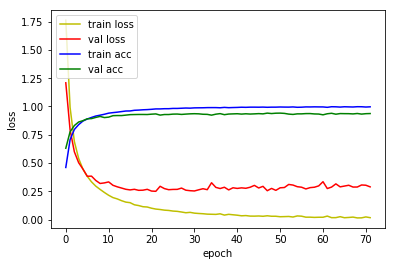

4815/4815 [==============================] - 2s 358us/sample - loss: 0.3084 - acc: 0.9103
Loss: 0.30844414250563484 Accuracy: 0.91028035



In [16]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_BN_2'.format(i)
    model = build_2d_cnn_only_conv_BN_2(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print('{} Only Conv Model'.format(i))
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()
    
    del(model)

In [17]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_BN_2'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


2D_CNN_1_only_conv_BN_2 Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 253, 95, 8)        32        
_________________________________________________________________
activation_10 (Activation)   (None, 253, 95, 8)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 48768)             0         
_________________________________________________________________
batch_normalization_v1_11 (B (None, 48768)             195072    
_________________________________________________________________
dense_4 (Dense)              (None, 16)      

4815/4815 [==============================] - 2s 415us/sample - loss: 0.3084 - acc: 0.9103
Loss: 0.30844414250563484 Accuracy: 0.91028035
